# Sec Recon Analyses

Here we perform different analyses to test the quality of secRecon

In [1]:
import datetime
import pickle
import networkx as nx

import re
import pandas as pd
import numpy as np
from Bio import Entrez
import Request_Utilis
from google_sheet import GoogleSheet
from collections import defaultdict

# Plotting libraries
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
from itertools import product

# Warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
Sec_Recon_SPREADSHEET_ID = '1L6qQQs48OdFd-mJcVqov_rSDoV90Ta0kib6UpL81OJQ'

# Initialize the GoogleSheet object
sec_recon_gsheet_file = GoogleSheet(Sec_Recon_SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from SecRecon
sec_genes_sheet = 'SecRecon'
ontology_sheet = 'Ontology'

sec_genes = sec_recon_gsheet_file.read_google_sheet(sec_genes_sheet)
ontology = sec_recon_gsheet_file.read_google_sheet(ontology_sheet)

### 1. Preprocessing of the data

In this section we'll use the networks generated in the Network_visualization notebook to visualize experimental data from a CHO High vs Low dataset

In [3]:
# Load datasets
cho_vs_plasma_prot = pd.read_excel('Data/cho_vs_plasma/1-s2.0-S1096717624000521-mmc3.xlsx',
                                   sheet_name = 'Proteome DE proteins')

cho_vs_plasma_rna = pd.read_excel('Data/cho_vs_plasma/1-s2.0-S1096717624000521-mmc3.xlsx',
                                   sheet_name = 'Transcriptome DE')

In [4]:
# Define dataset and condition
df = cho_vs_plasma_prot #cho_vs_plasma_rna
cond = 'FC PCD/CHO' #Fold-Change CHO/Human

In [5]:
# Load gene_dict from SecRecon

with open('gene_dict.pkl', 'rb') as f:
    gene_dict = pickle.load(f)

In [6]:
# Load G string for plotting
G = nx.read_graphml('Network/sec_recon_network.graphml')

In [7]:
# Map Mouse genes to Human genes

dict_mouse_human = dict(zip(sec_genes['MOUSE GENE SYMBOL'], sec_genes['GENE SYMBOL']))
df['Human_Genes'] = df['Mmus_Genes'].map(dict_mouse_human)

In [8]:
# Filtering

# Filter rows where 'Human_Genes' is not NaN
filtered_df = df[df['Human_Genes'].notna()]

# Filter the dictionary based on the filtered_df
filtered_gene_dict = {gene: info for gene, info in gene_dict.items() if gene in filtered_df['Human_Genes'].values}

# Filter the graph G based on the filtered_gene_dict
nodes_to_remove = [node for node in G.nodes if node not in filtered_gene_dict]
G.remove_nodes_from(nodes_to_remove)

In [9]:
# Normalize the 'FC PCD/CHO' column to the range [0.005, 0.025] in the filtered_df

# Apply log transformation to 'FC PCD/CHO' column
filtered_df['log'] = np.log1p(filtered_df[cond])  # Use log1p to handle zero values

min_val = 0.001
max_val = 0.035

filtered_df['normalized_log'] = ((filtered_df['log'] - filtered_df['log'].min()) / 
                                (filtered_df['log'].max() - filtered_df['log'].min())) * (max_val - min_val) + min_val


/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_2171/768209539.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log'] = np.log1p(filtered_df[cond])  # Use log1p to handle zero values
/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_2171/768209539.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['normalized_log'] = ((filtered_df['log'] - filtered_df['log'].min()) /


In [ ]:
# Extract positions from the graph
pos = {node: (float(data['x']), float(data['y'])) for node, data in G.nodes(data=True)}

In [13]:
for i,row in filtered_df.iterrows():
    g = row['Human_Genes']
    if g in gene_dict.keys():
        filtered_gene_dict[g]['Expression'] = float(row['normalized_log'])

In [14]:
from scipy import interpolate
# Fit a linear model (for simplicity) or use interpolation
x = filtered_df['FC PCD/CHO']
y = filtered_df['normalized_log']

# Interpolate to find the value
interp_func = interpolate.interp1d(x, y, fill_value="extrapolate")
normalized_log_cutoff = interp_func(2)

print(f'The cutoff in the normalized_log column for FC PCD/CHO = 2 is approximately: {normalized_log_cutoff}')

The cutoff in the normalized_log column for FC PCD/CHO = 2 is approximately: 0.005902234637839655


### 2. Plotting on secRecon Ontology

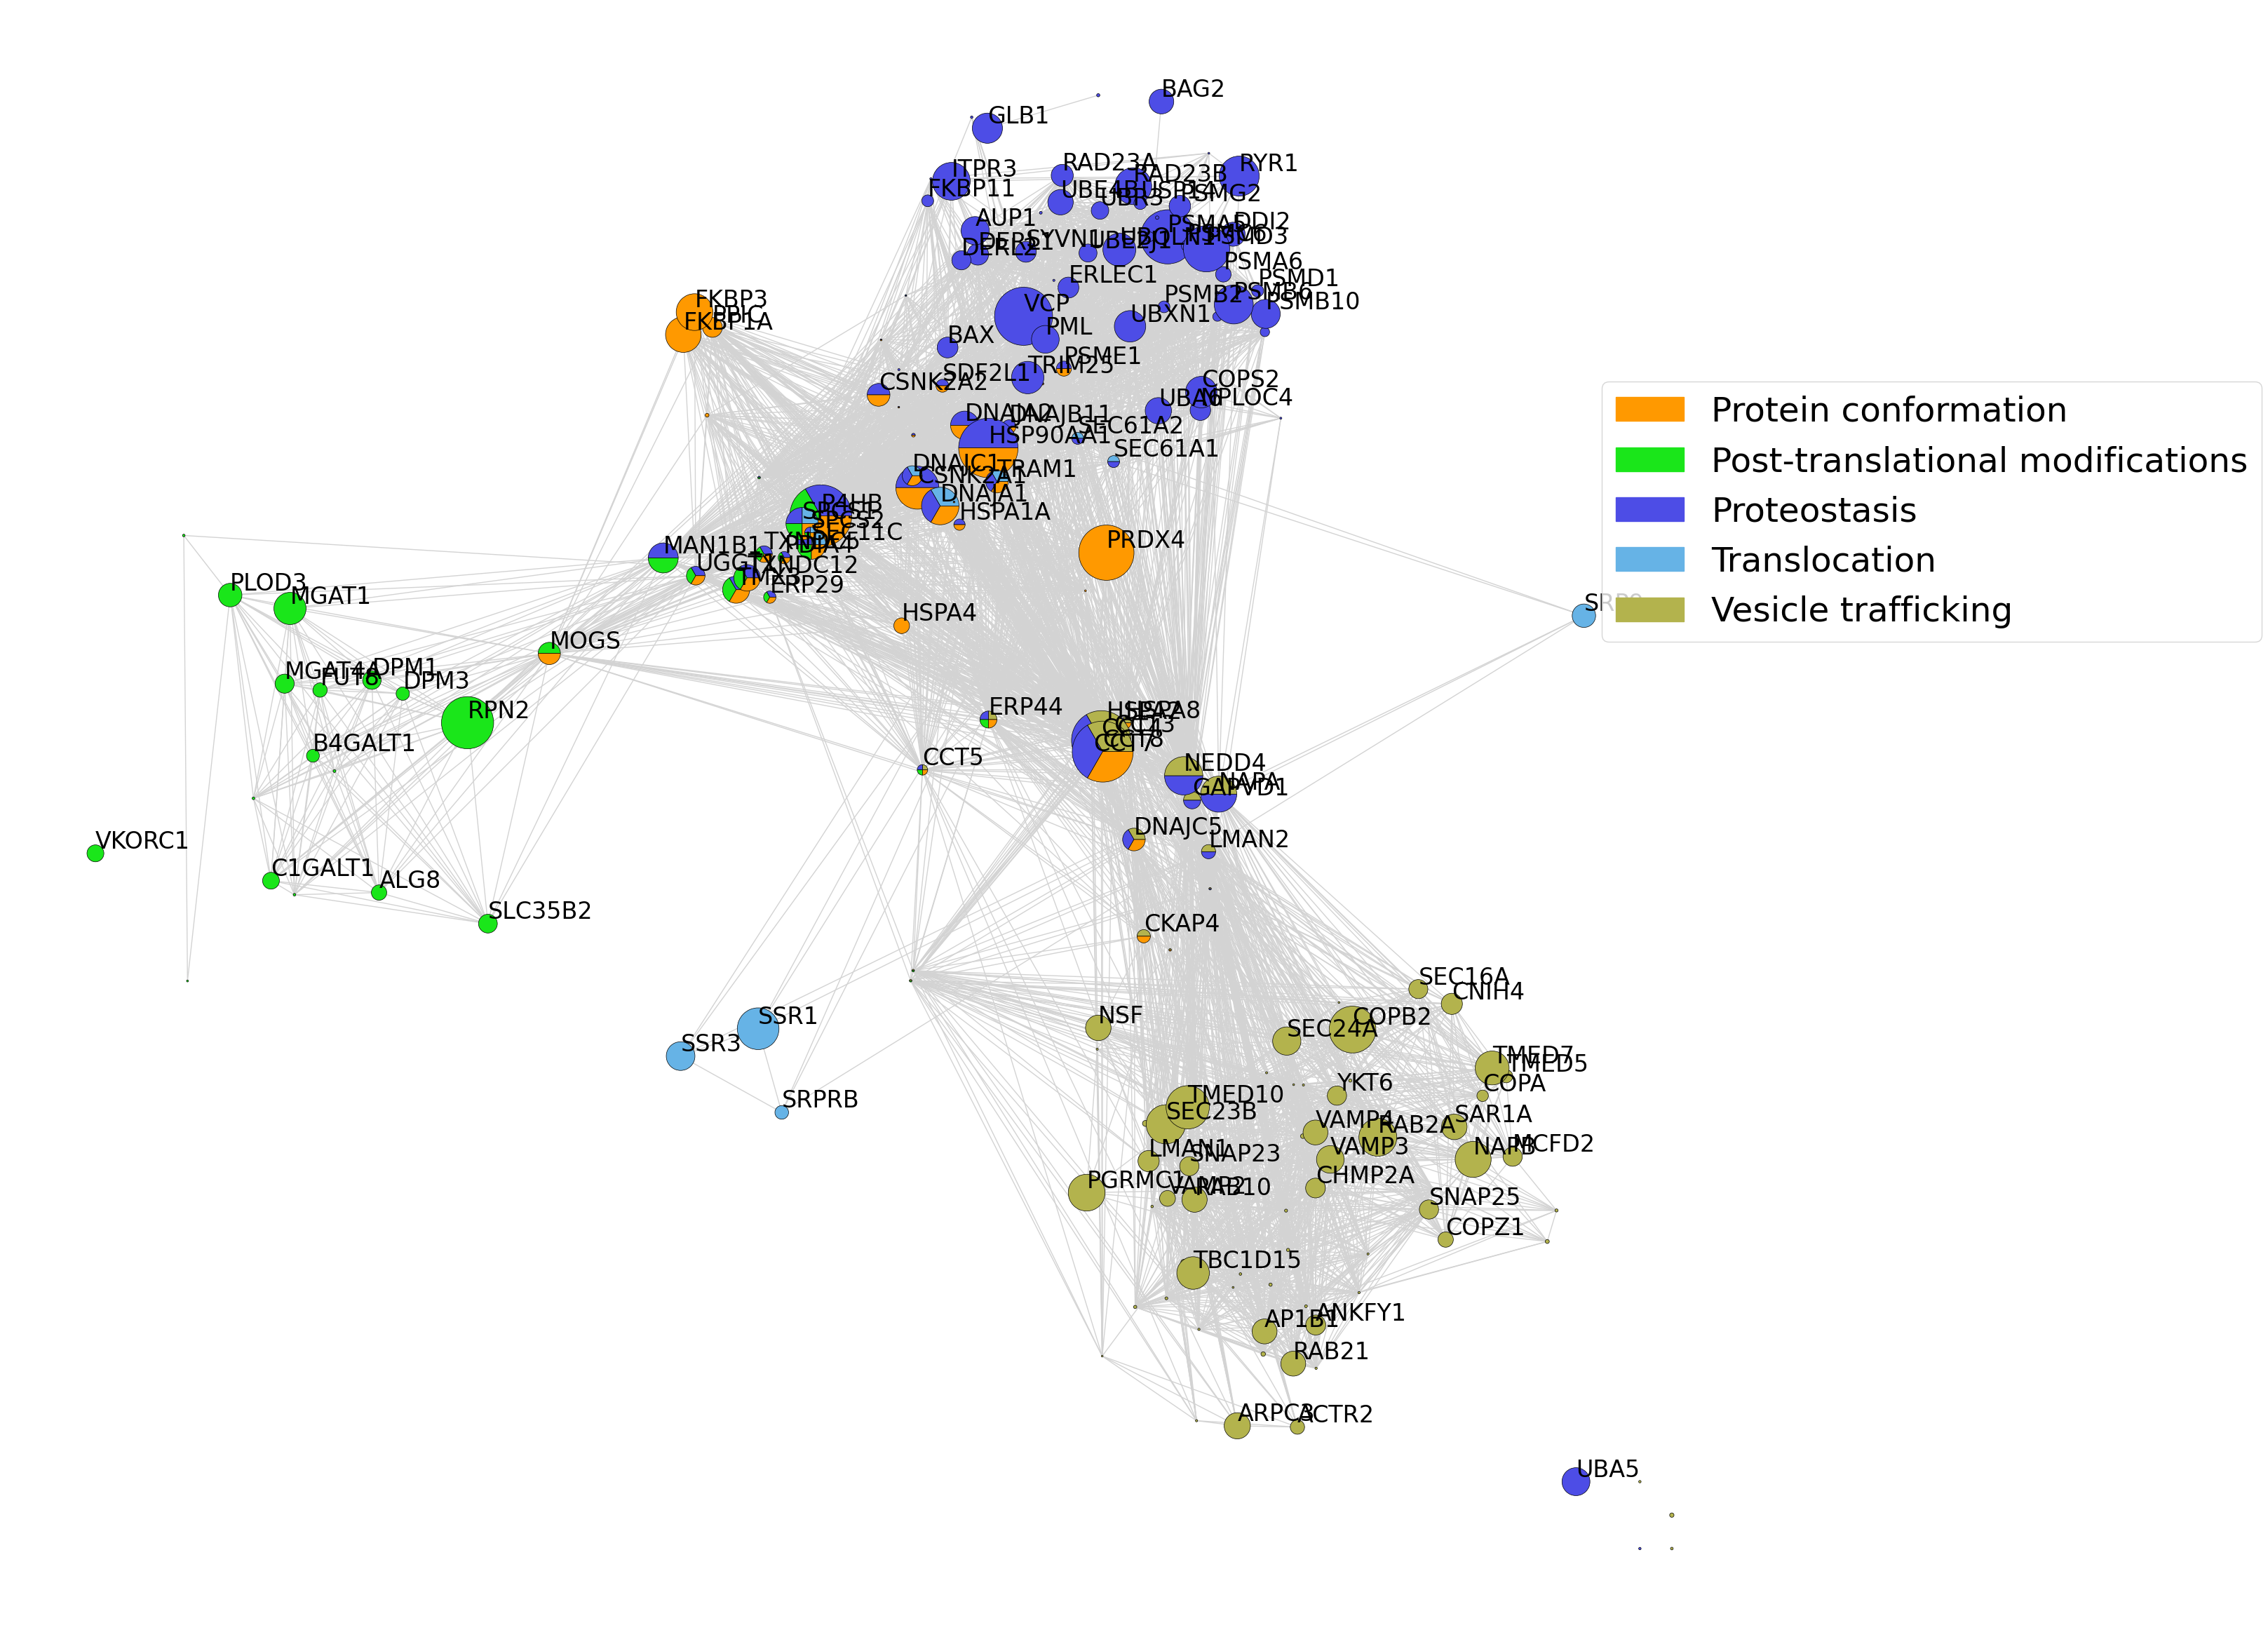

In [24]:
system_colors = {
    'Protein conformation': (1.0, 0.6, 0.0, 1.0),
    'Post-translational modifications': (0.1, 0.9, 0.1, 1.0), 
    'Proteostasis': (0.3, 0.3, 0.9, 1.0),
    'Translocation': (0.4, 0.7, 0.9, 1.0),
    'Vesicle trafficking': (0.7, 0.7, 0.3, 1.0)
}

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])

    
# Draw nodes as pie charts
for node, (x, y) in pos.items():
    systems = gene_dict[node]['systems']
    
    # Adjust the alpha value of each color
    colors = [system_colors[sys] for sys in systems]
    
    # Draw pie chart at node position with edgecolor and linewidth
    radius = filtered_gene_dict[node]['Expression']
    ax.pie([1]*len(systems), colors=colors, radius=radius, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
     # Add label if expression exceeds the threshold
    if radius > 0.0059:
        ax.text(x, y, node, fontsize=24, ha='left', va='bottom')

# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in system_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 35}, loc='lower left', bbox_to_anchor=(0.9, 0.6))
plt.subplots_adjust(right=0.75)

plt.savefig('Network_cho_vs_plasma/secRecon_cho_vs_plasma_systems.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

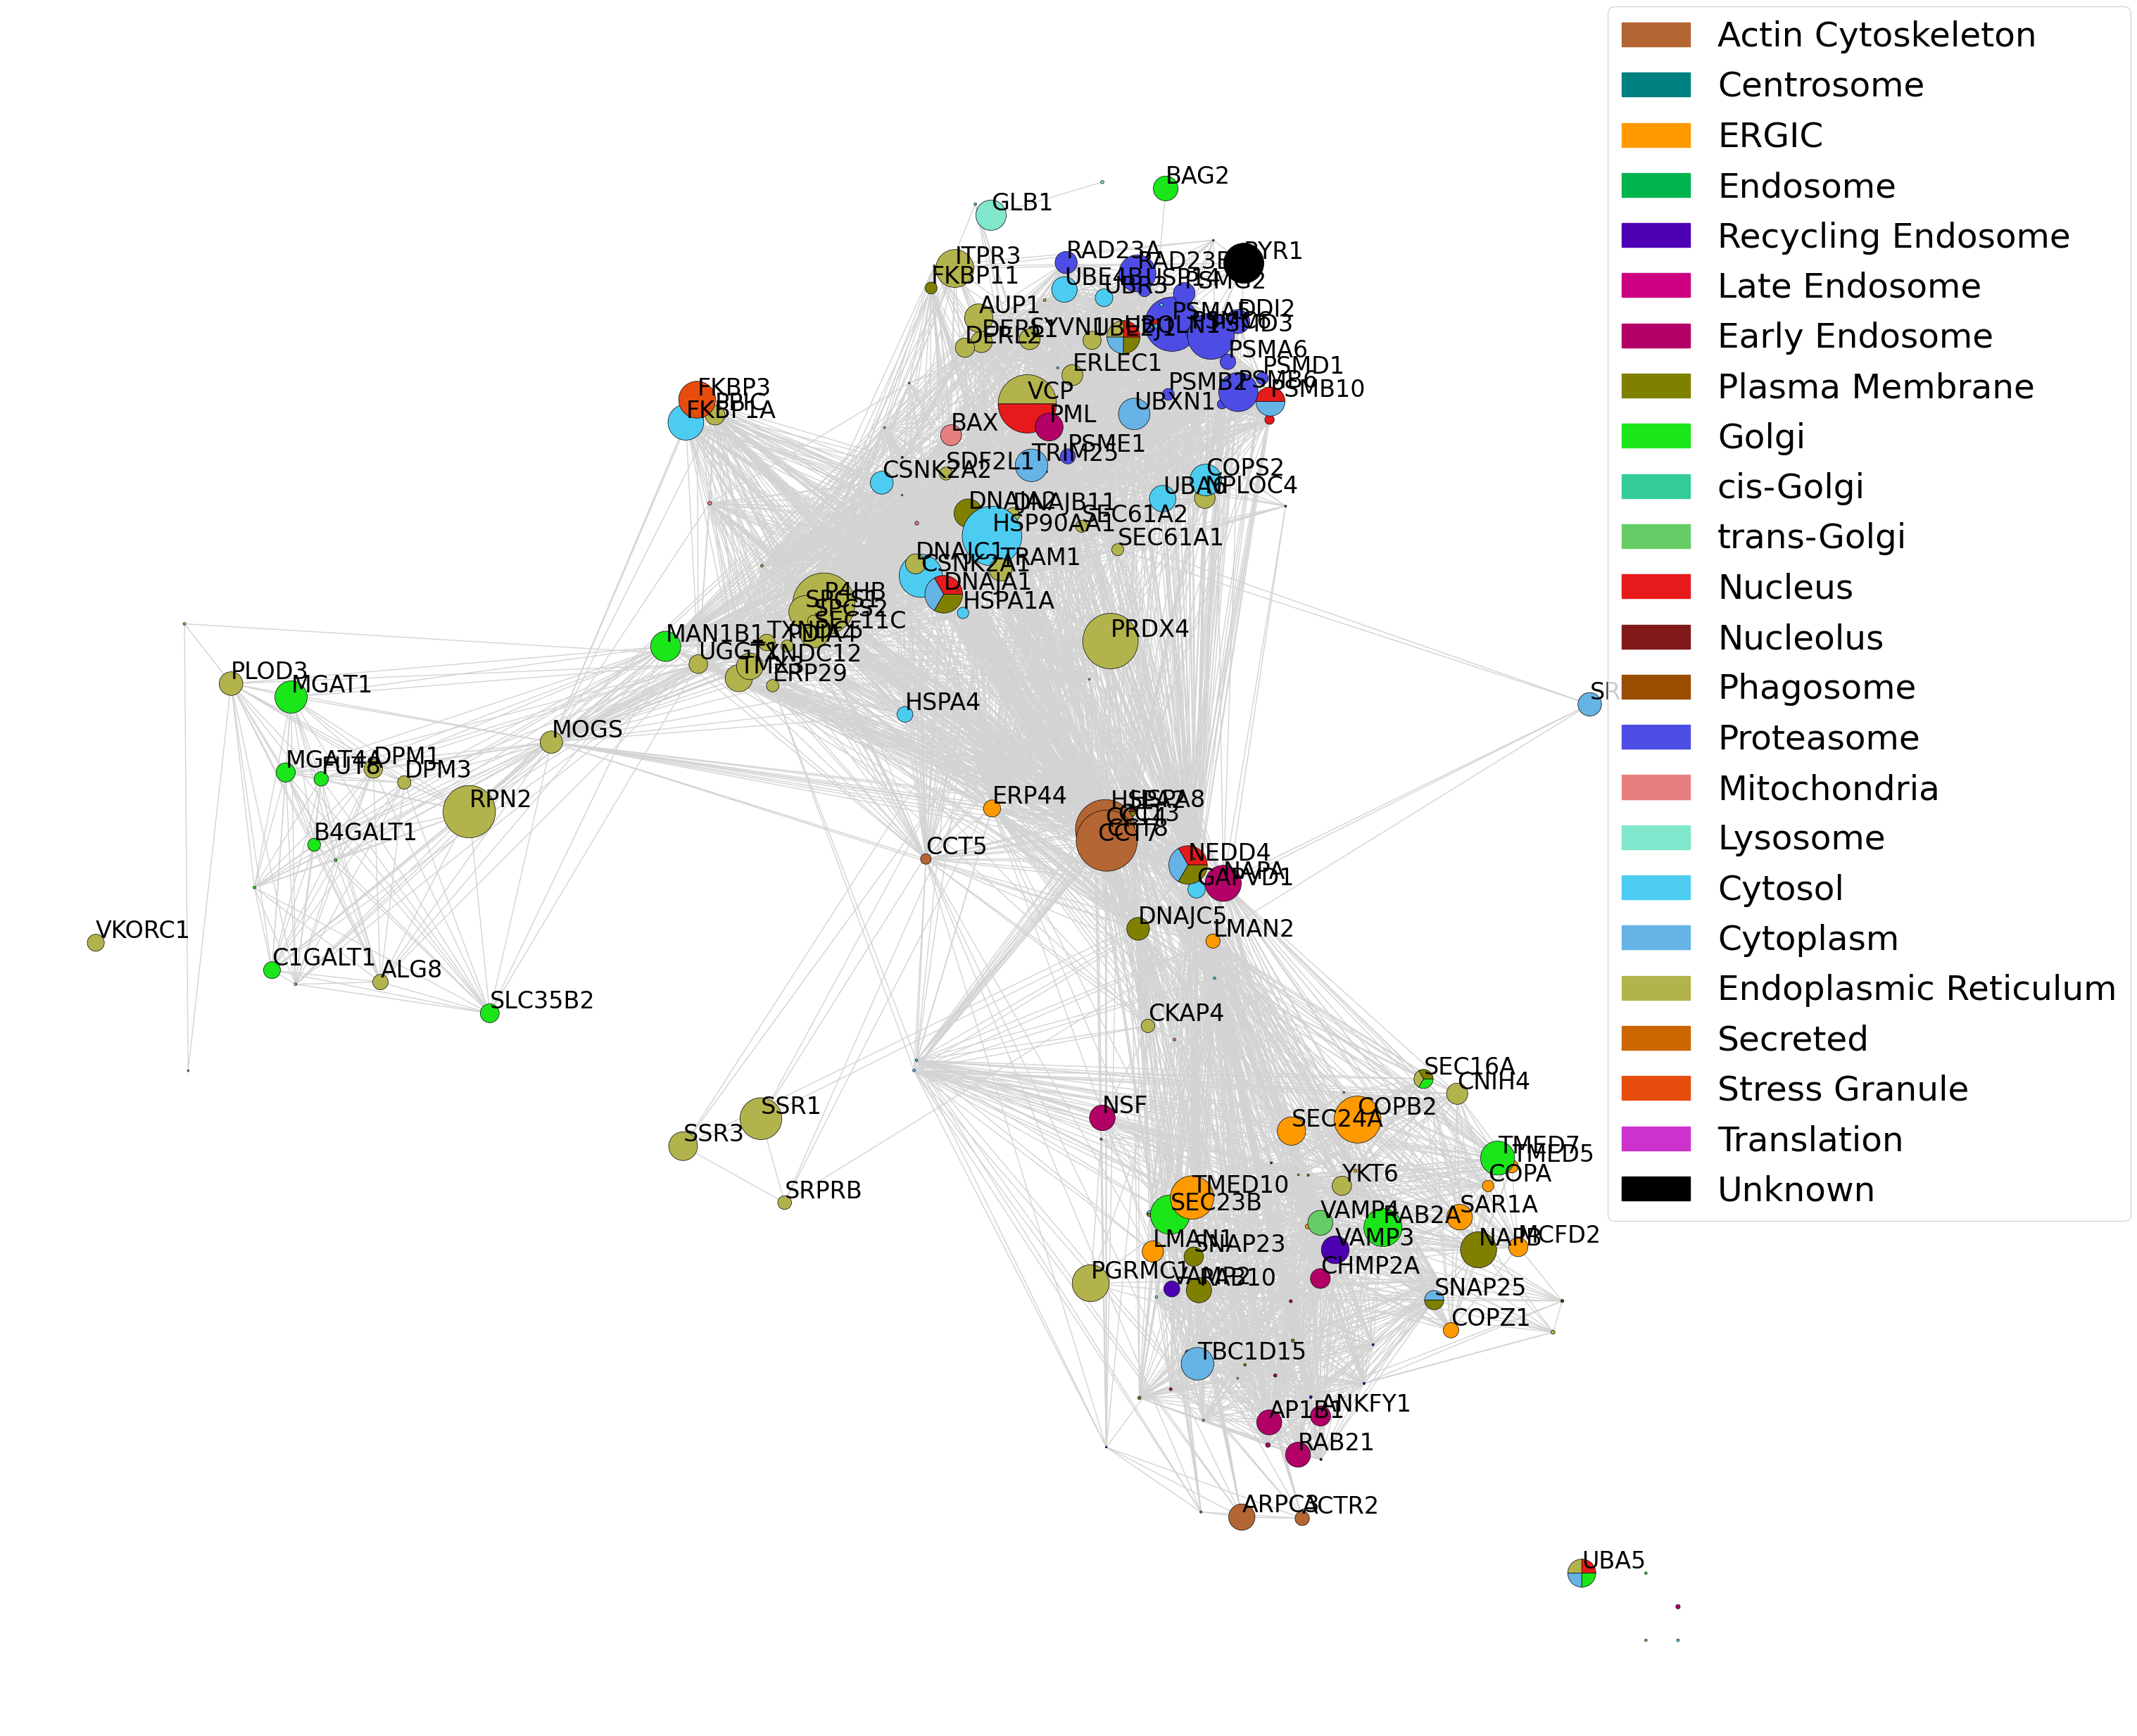

In [23]:
localization_colors = {
    'Actin Cytoskeleton': (0.7, 0.4, 0.2, 1.0),
    'Centrosome': (0.0, 0.5, 0.5, 1.0),
    'ERGIC': (1.0, 0.6, 0.0, 1.0),
    'Endosome': (0.0, 0.7, 0.3, 1.0), 
    'Recycling Endosome': (0.3, 0.0, 0.7, 1.0),
    'Late Endosome': (0.8, 0.0, 0.5, 1.0),
    'Early Endosome': (0.7, 0.0, 0.4, 1.0), 
    'Plasma Membrane': (0.5, 0.5, 0.0, 1.0), 
    'Golgi': (0.1, 0.9, 0.1, 1.0), 
    'cis-Golgi': (0.2, 0.8, 0.6, 1.0),
    'trans-Golgi': (0.4, 0.8, 0.4, 1.0), 
    'Nucleus': (0.9, 0.1, 0.1, 1.0),
    'Nucleolus': (0.5, 0.1, 0.1, 1.0),
    'Phagosome': (0.6, 0.3, 0.0, 1.0),
    'Proteasome': (0.3, 0.3, 0.9, 1.0),
    'Mitochondria': (0.9, 0.5, 0.5, 1.0),
    'Lysosome': (0.5, 0.9, 0.8, 1.0),  
    'Cytosol': (0.3, 0.8, 0.95, 1.0),
    'Cytoplasm': (0.4, 0.7, 0.9, 1.0),
    'Endoplasmic Reticulum': (0.7, 0.7, 0.3, 1.0),
    'Secreted': (0.8, 0.4, 0.0, 1.0),
    'Stress Granule': (0.9, 0.3, 0.05, 1.0),
    'Translation': (0.8, 0.2, 0.8, 1.0),
    'Unknown': (0.0, 0.0, 0.0, 1.0)
}

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])


# Draw nodes as pie charts
for node, (x, y) in pos.items():
    localizations = gene_dict[node]['subcellular_localization']
    
    # Adjust the alpha value of each color
    colors = [localization_colors[loc] for loc in localizations]
    
    # Draw pie chart at node position with edgecolor and linewidth
    radius = filtered_gene_dict[node]['Expression']
    ax.pie([1]*len(localizations), colors=colors, radius=radius, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
     # Add label if expression exceeds the threshold
    if radius > 0.0059:
        ax.text(x, y, node, fontsize=24, ha='left', va='bottom')
    
# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 35}, loc='lower left', bbox_to_anchor=(0.9, 0.3))
plt.subplots_adjust(right=0.75)

plt.savefig('Network_cho_vs_plasma/secRecon_cho_vs_plasma_localization.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### 3. Plotting on Protein-Protein Interactions

In [11]:
from pp_interactions import visualize_network

In [25]:
G_ppi = nx.read_graphml('Network/string_interactions_sec_recon.graphml')

# Filter the G PPI based on the filtered_gene_dict
nodes_to_remove = [node for node in G_ppi.nodes if node not in filtered_gene_dict]
G_ppi.remove_nodes_from(nodes_to_remove)

# Extract positions from the graph
pos = {node: (float(data['x']), float(data['y'])) for node, data in G_ppi.nodes(data=True)}

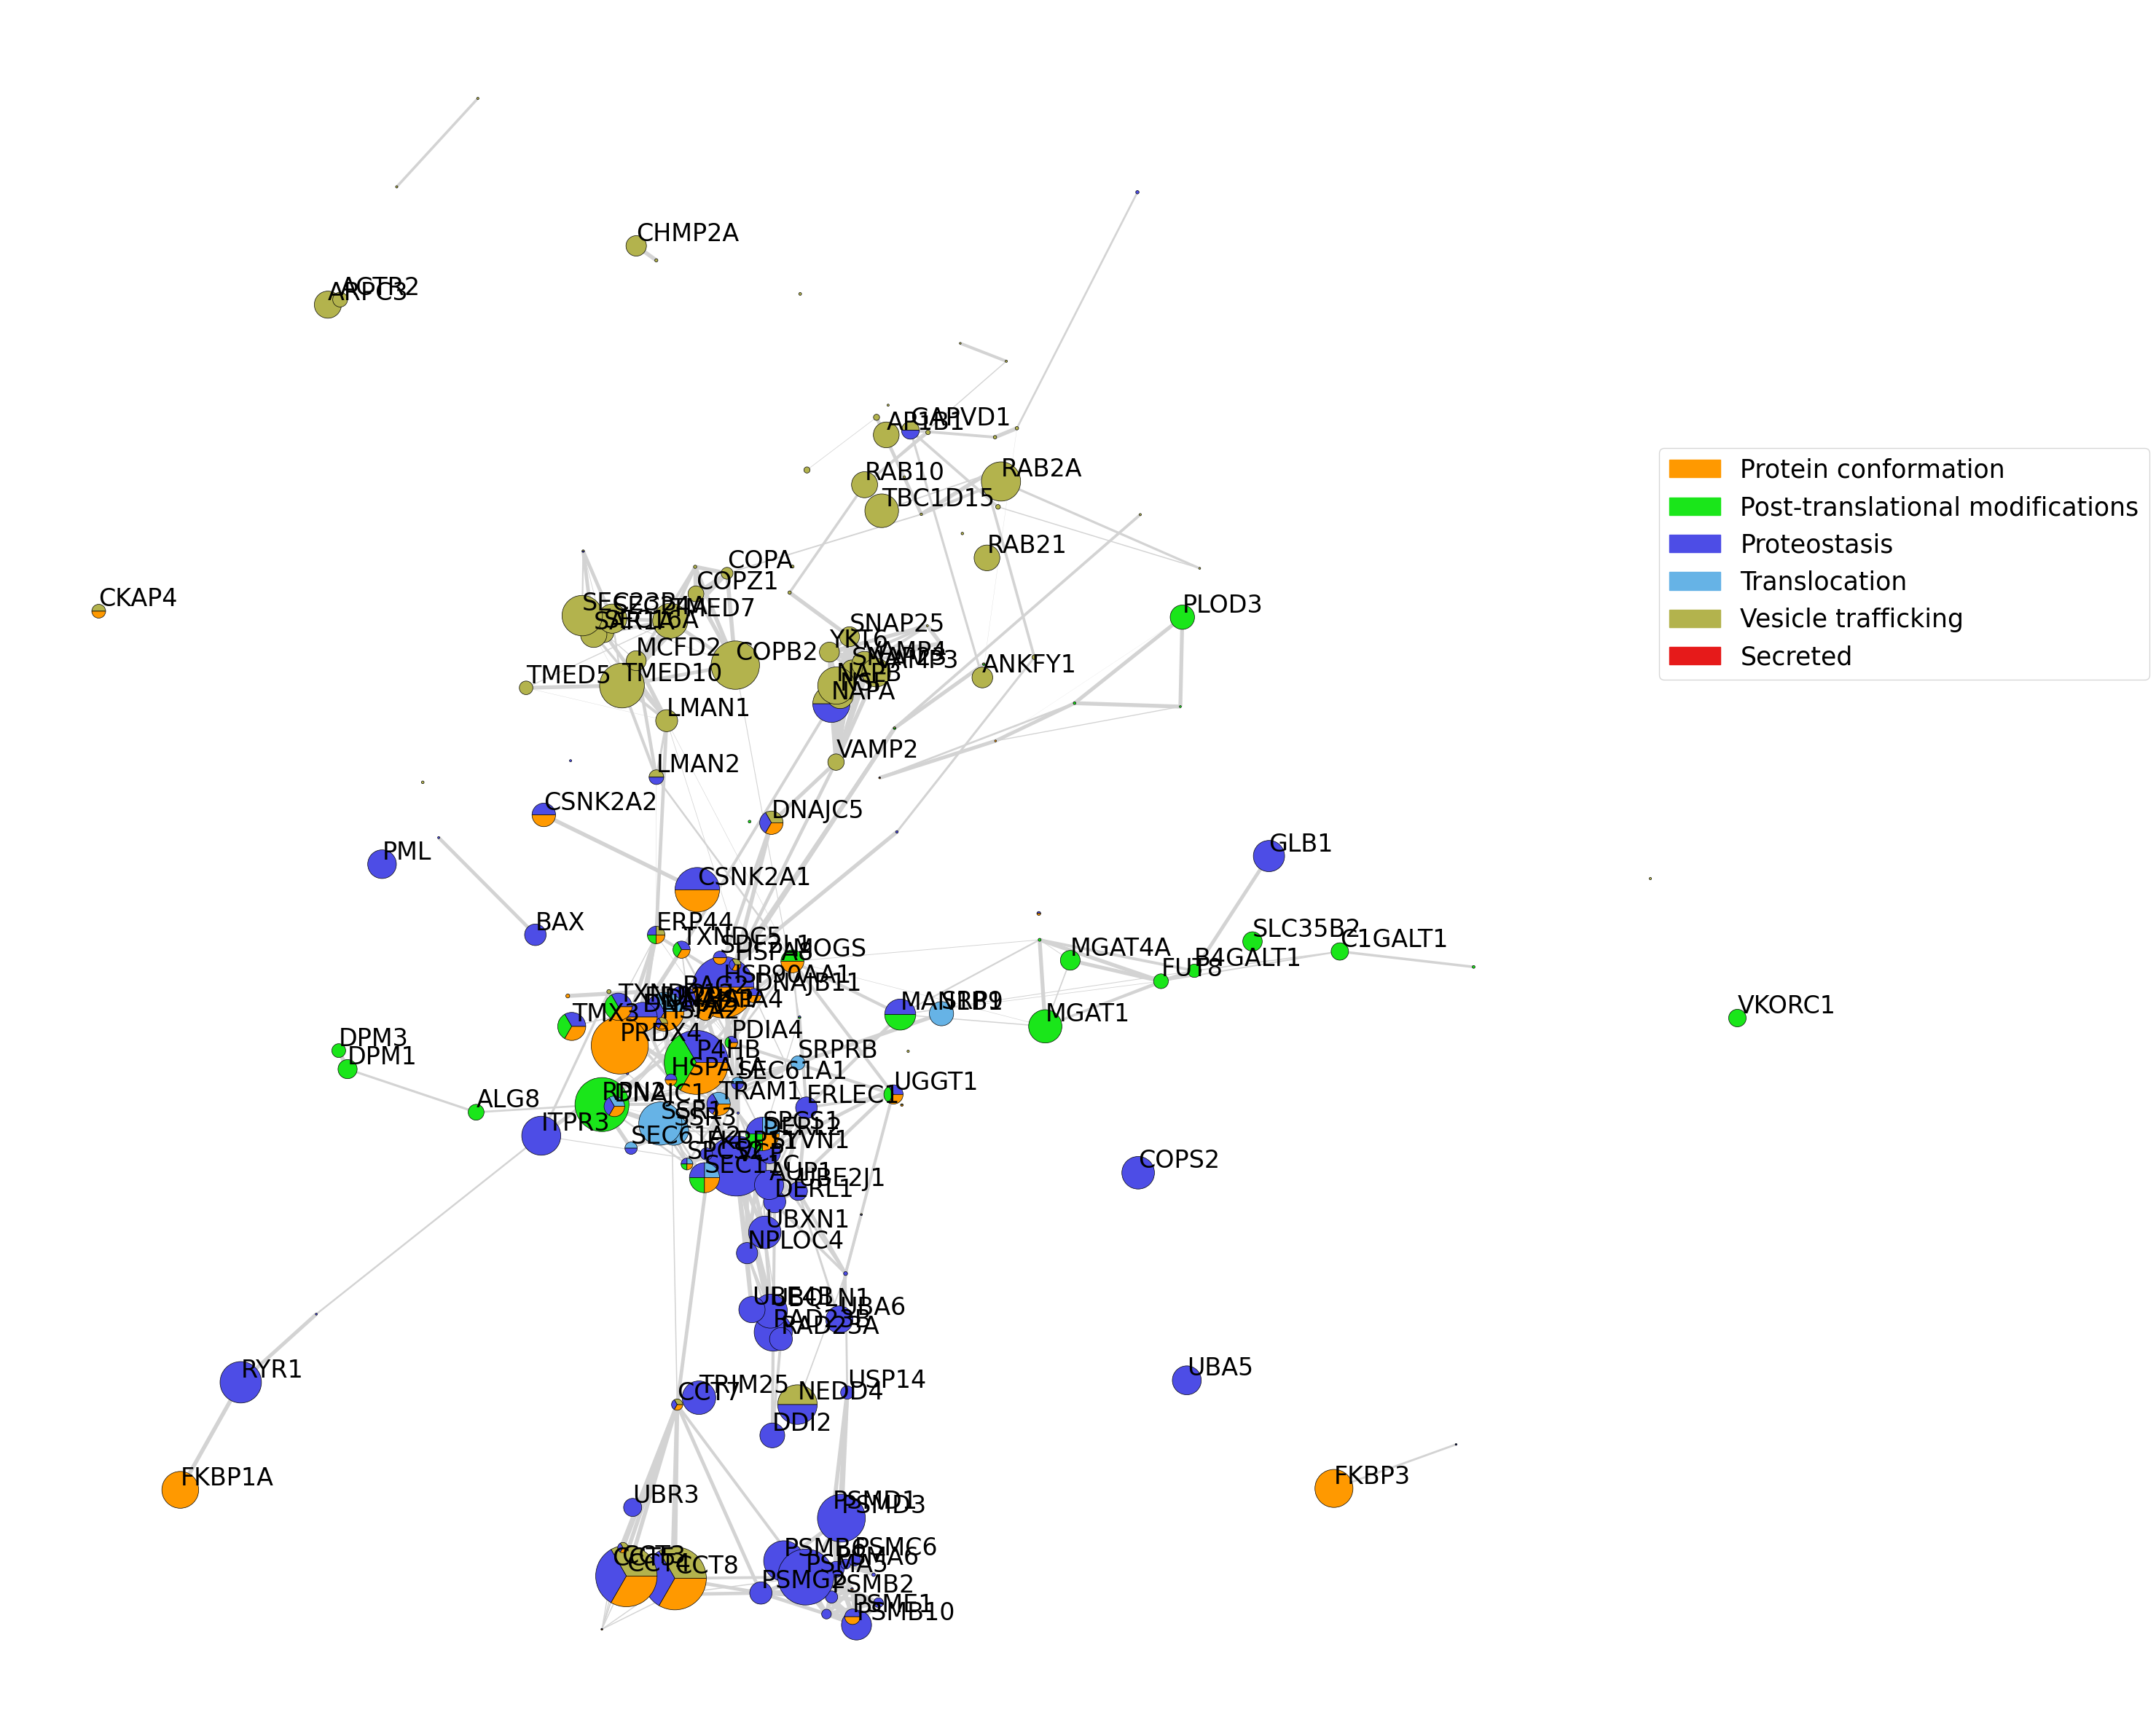

In [26]:
filename = f"Network_cho_vs_plasma/STRING_cho_vs_plasma_systems.png"
visualize_network(G_ppi, filtered_gene_dict, pos, filename=filename, node_size='exp', color_by='systems', legends=True, label_threshold=0.0059)

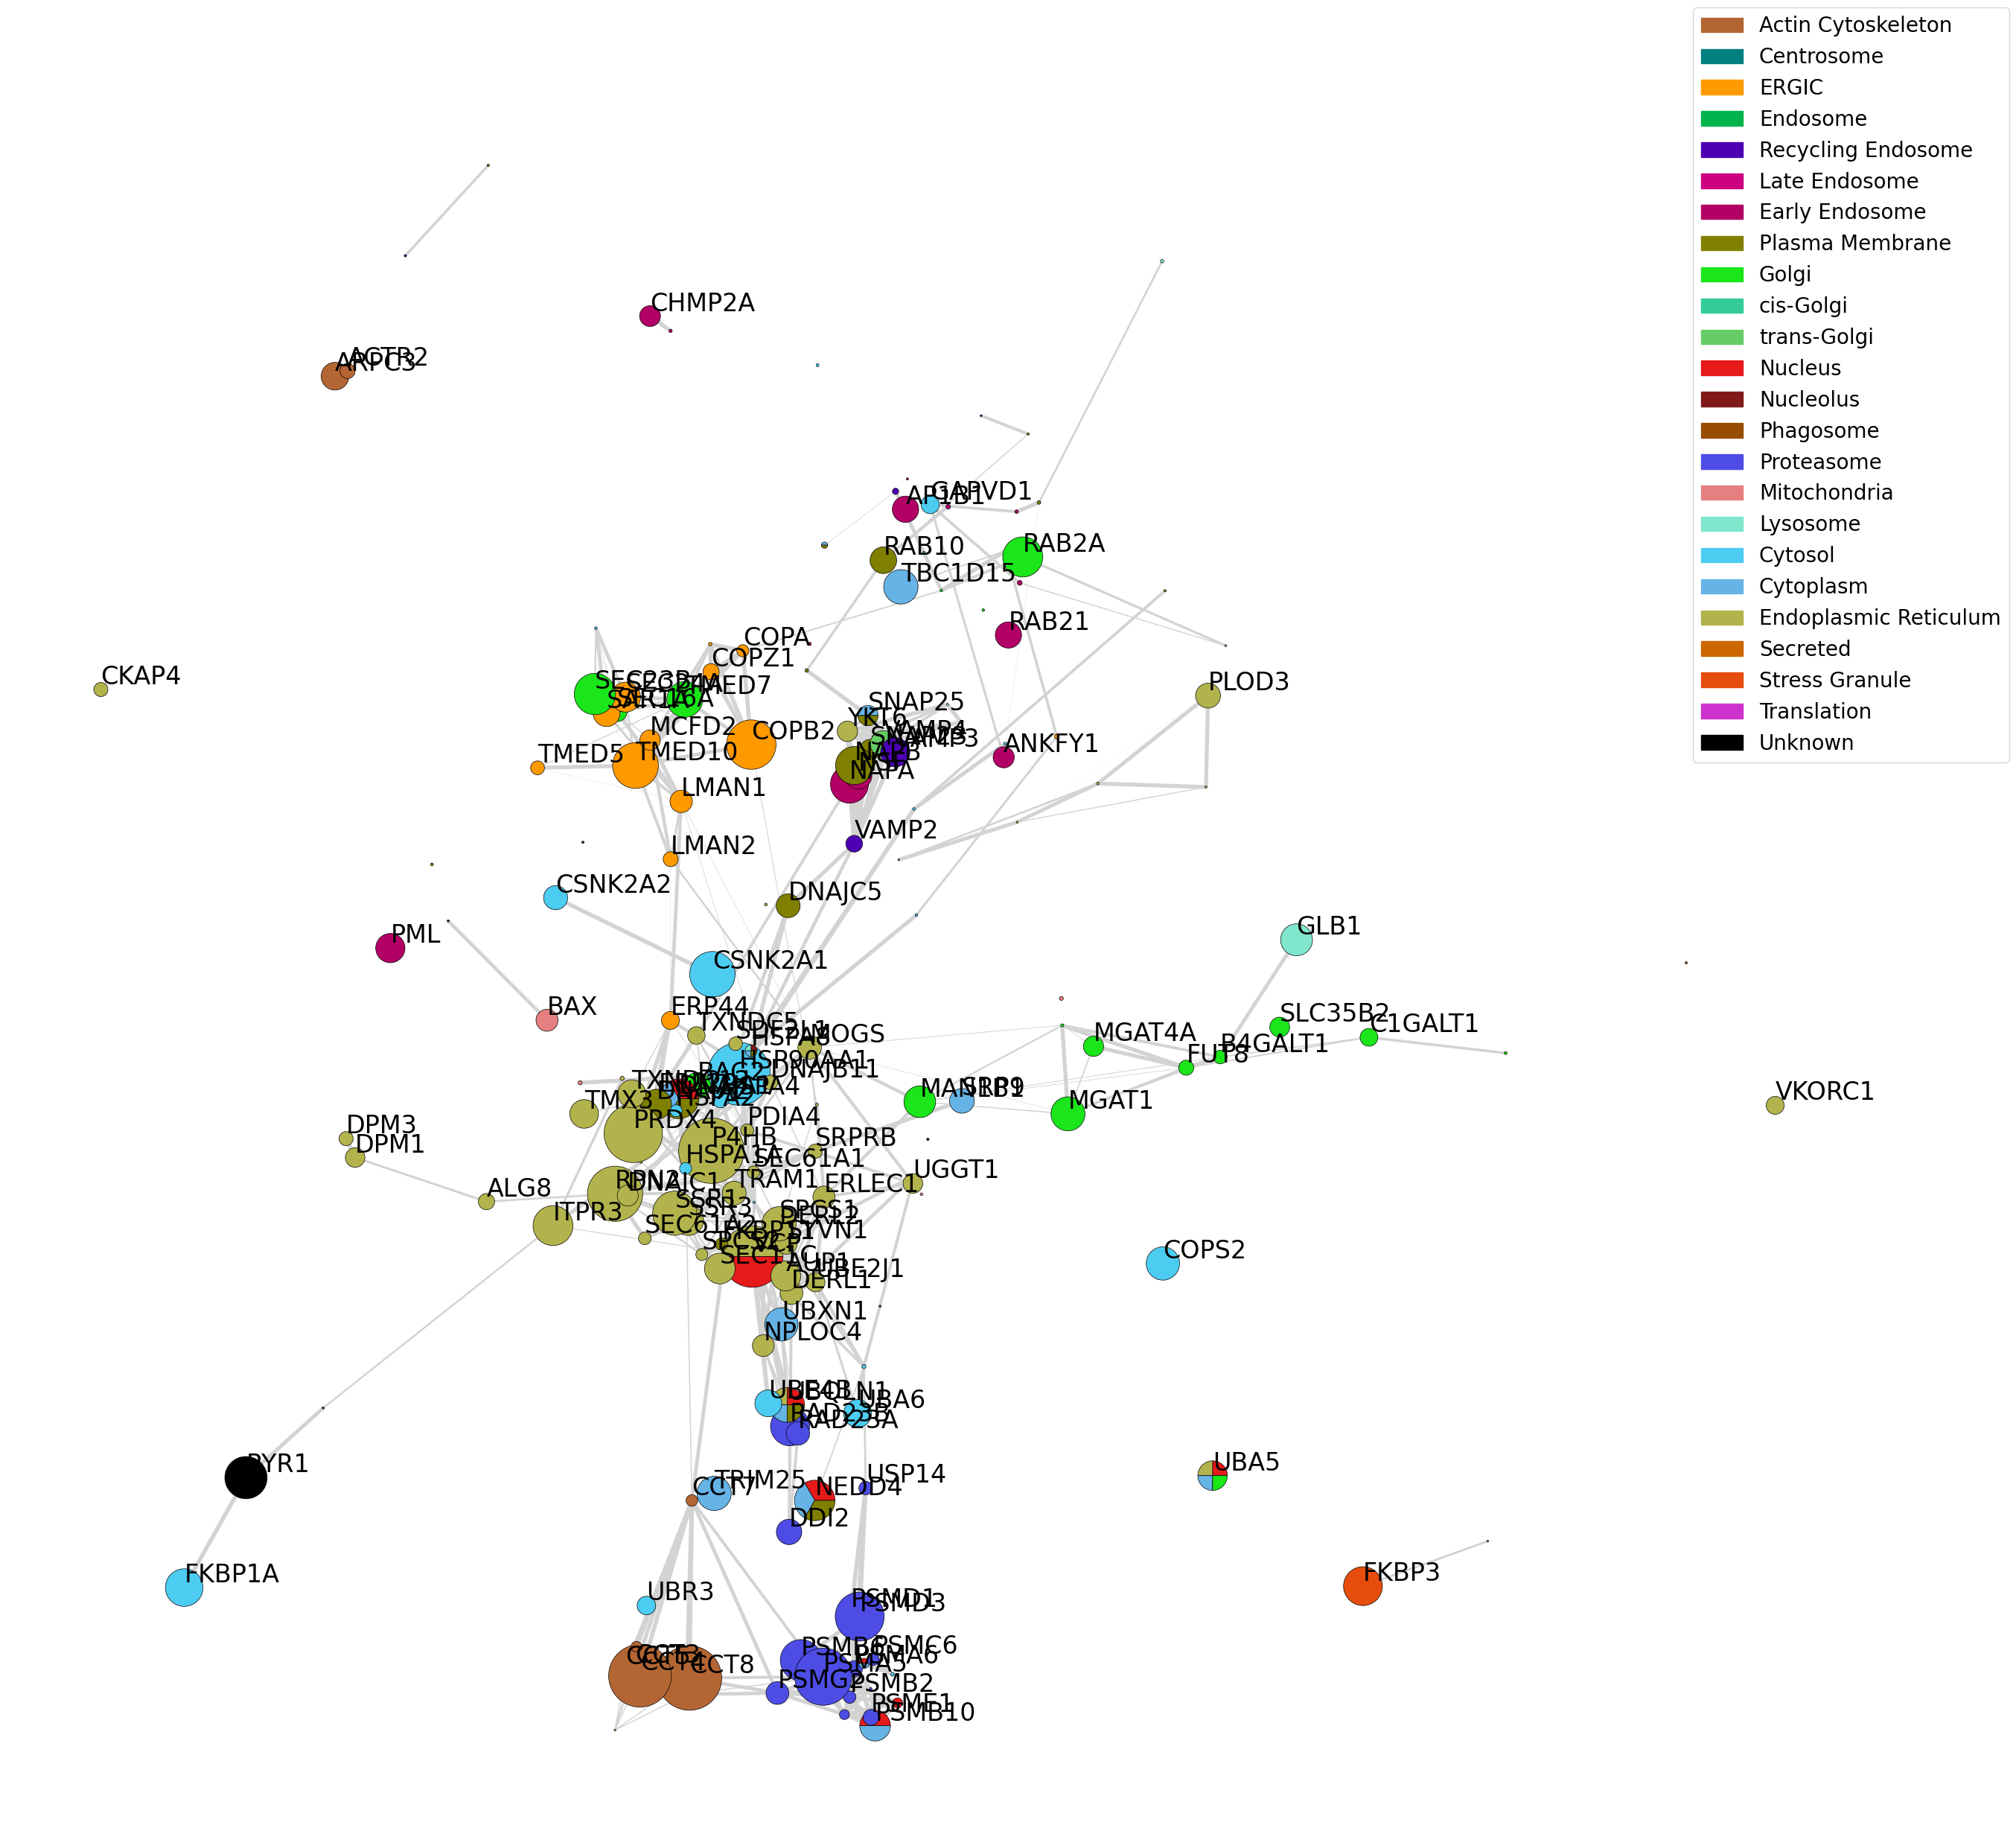

In [27]:
filename = f"Network_cho_vs_plasma/STRING_cho_vs_plasma_localization.png"
visualize_network(G_ppi, filtered_gene_dict, pos, filename=filename, node_size='exp', color_by='localization', legends=True, label_threshold=0.0059)